# TP 4 : Approximation Functions & Deep Q-learning

We want to extend the methods we have seen for discrete state spaces to problems with arbitrarily large state spaces. In the case of a video game for example, the number of possible images is often larger than the number of atoms in the observable universe. We generally can't expect to build a Q-table.  


Our goal instead is to find a good approximate solution using limited computational resources.  Because we will encounter states never seen before, we need to use data from previous encounter to perform generalization. We will see function approximation as a generalization method. Function approximation is a supervised learning problem, as such we will be using methods you have seen in Machine Learning courses.

> The most important parts (with almost all the points in the implementation and analysis ) are for MC, TD0 and n-step TD algorithm.  Deep Q-learning is added for you to experiment. Stuff might break. It might take a long time to converge.

Please send this practical with plots before next course to cyriaque.rousselot@inria.fr If your file is too big due to videos, share a link to the videos folder instead.

## Approximation Functions

In this project, you are asked to solve the classic Mountain Car Problem (https://gymnasium.farama.org/environments/classic_control/mountain_car/#mountain-car). Unlike previous environment, states are continuous so that you need to approximate the Q values Q(s, a). The goal is to push the cart to the flag. 


![ChessUrl](https://gymnasium.farama.org/_images/mountain_car.gif "Frozen Lake")

In [1]:
## Packages required
# !pip install moviepy scipy opencv-python gymnasium[atari,accept-rom-license,classic-control] torch

     ---------------------------------------- 0.0/388.3 kB ? eta -:--:--
     - -------------------------------------- 10.2/388.3 kB ? eta -:--:--
     ------------ ------------------------- 122.9/388.3 kB 1.8 MB/s eta 0:00:01
     ------------------------------------ - 368.6/388.3 kB 3.3 MB/s eta 0:00:01
     -------------------------------------- 388.3/388.3 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for imageio_ffmpeg>=0.2.0 from https://files.pythonhosted.org/packages/c6/01/716106099e48c4f419876d5814679a94dd7d6f441217c97c1b608123c6bb/imageio_ffmpeg-0.4.9-py3-none-win_amd64.whl.metadata
     ---------------------------------------- 0.0/434.7 kB ? eta -:--:--
     ----------------- -------------------- 194.6/434.7 kB 5.9 MB/s eta 0:00:01
     ----------------------------------- -- 409.6/434.7 kB 5.1 MB/s eta 0:00:01
     -------------------------------------  430.1/43

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 1
%aimport utils
%matplotlib inline

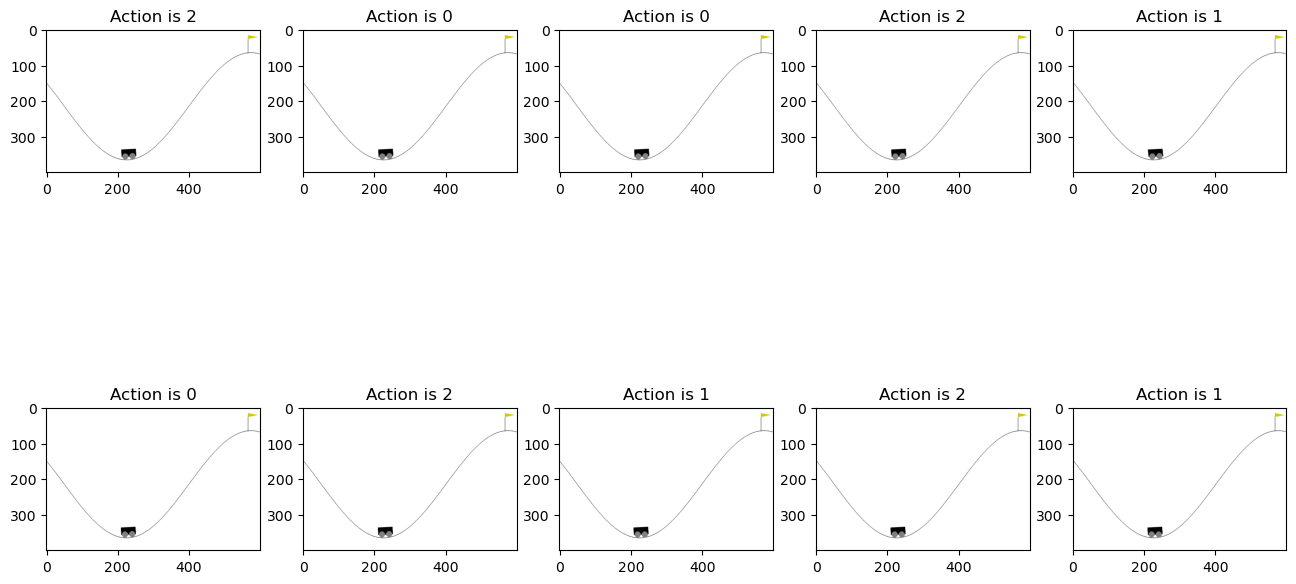

In [2]:
## Let's plot the impact of several action
env = utils.WithSnapshots(gym.make("MountainCar-v0", render_mode="rgb_array"))
state, _ = env.reset()
n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render())
        action = env.action_space.sample()
        ax.set_title(f"Action is {action}")
        env.step(action)

plt.show()
env.close()

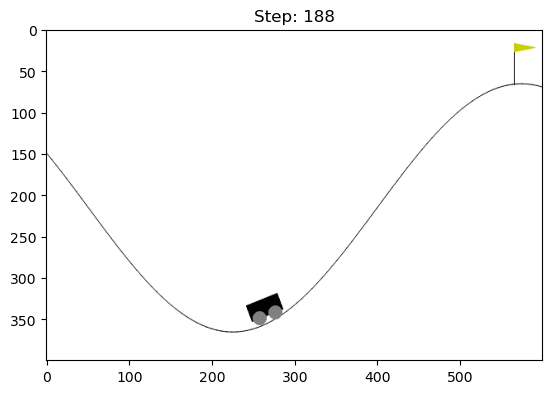

Time is over!


In [3]:
import time
from IPython.display import clear_output
steps_alive = 0
sleep_time = 0.01

while True:
    _, _, terminated, truncated, _ = env.step(env.action_space.sample())

    if terminated:
        print("Whoops! We died!")
        break
    if truncated:
        print("Time is over!")
        break
    clear_output(wait=True)
    # plot env state to screen
    plt.imshow(env.render())
    plt.title("Step: %d" %(steps_alive))
    plt.show()
    #time.sleep(sleep_time)
    steps_alive += 1

Time is over!
final state:


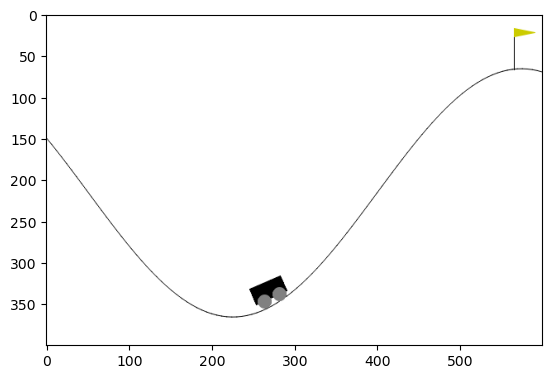

In [4]:
env.reset()
while True:
    env.render()
    _, _, terminated, truncated, _ = env.step(env.action_space.sample())
    if terminated:
        print("Whoops! We died!")
        break
    if truncated:
        print("Time is over!")
        break

print("final state:")
plt.imshow(env.render())
env.close()

### Agent Template

In [5]:
class Agent:
    def choose(self, state):
        return env.action_space.sample()


def generate_session(env, agent):
    """play env with agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    while True:
        a = agent.choose(s)
        observation, reward, terminated, truncated, info = env.step(a)
        total_reward += reward
        s = observation
        if terminated or truncated:
            break

    return total_reward

## Output a video (not mandatory)

In [6]:
# # Record sessions

# from gymnasium.wrappers import RecordVideo

# env = gym.make("MountainCar-v0", render_mode="rgb_array", max_episode_steps=1000)
# env = RecordVideo(env, video_folder="videos")
# env = utils.WithSnapshots(env)
# generate_session(
#     env,
#     Agent(),
# )
# env.close()

In [7]:
# # Show video. This may not work in some setups. If it doesn't
# # work for you, you can download the videos and view them locally.

# from pathlib import Path
# from base64 import b64encode
# from IPython.display import HTML

# video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
# video_path = video_paths[-1]  # You can also try other indices
# data_url = str(video_path)

# HTML(
#     """
# <video width="640" height="480" controls>
#   <source src="{}" type="video/mp4">
# </video>
# """.format(
#         data_url
#     )
# )

In [8]:
# use the snapshot to suggest effect of an action, then load back the snapshot
def suggest_model(action, env):
    snap0 = env.get_snapshot()
    observation, reward, terminated, truncated, info = env.step(action)
    env.load_snapshot(snap0)
    return (observation, reward, terminated, truncated)

In [9]:
import numpy as np


class RandomAgentQ:
    """Dummy Agent"""

    def __init__(self):
        pass

    def add_env(self, env):
        self.env = env

    def preprocessing(self, state):
        """
        Return the featurized representation of a state.
        """
        pass

    def act(self, state):
        """Output optimal action of a given state
        Return: action in [0, 1, 2]
        """
        return np.random.choice([0, 1, 2])

    def update(self, s1, a1, r1, s2):
        pass

    def q(self, state, action):
        """Final Q function.
        Value (scalar): Q(state, action)
        """
        return np.random.uniform(0, 1)

In [10]:
def loop_train(agent, n_episodes=3, max_iter=10, verbose=True):
    env = gym.make(
        "MountainCar-v0", render_mode="rgb_array", max_episode_steps=max_iter
    )
    # env = RecordVideo(env, video_folder="videos")
    env = utils.WithSnapshots(env)
    agent.add_env(env)
    cumul_reward = 0
    list_n_episodes = []
    for g in range(n_episodes):
        print(f"Episode {g+1}")
        state, _ = env.reset()
        stop = False
        i = 0
        s_reward = 0
        while not stop:
            if verbose:
                print("Simulation step {}:".format(i))
            action = agent.act(state)
            observation, reward, terminated, truncated, info = env.step(action)
            stop = terminated or truncated
            agent.update(state, action, reward, observation)

            cumul_reward += reward
            s_reward += reward
            if verbose:
                print(" ->       game: {}".format(g))
                print(" ->       observation: {}".format(state))
                print(" ->            action: {}".format(action))
                print(" ->            reward: {}".format(reward))
                print(" -> cumulative reward: {}".format(s_reward))
                if stop:
                    print(" ->    Terminal event: {}".format(observation))
                    input()
                print("")
            i += 1
            state = observation
        list_n_episodes.append(s_reward)
        if verbose:
            print(" <=> Finished episode number: {} <=>".format(g + 1))
            print("")
    return cumul_reward, list_n_episodes

In [11]:
agent = RandomAgentQ()
cumul_reward, list_n_episodes = loop_train(agent, verbose=False)

Episode 1
Episode 2
Episode 3


> Q.0 Build a loop to evaluate your agent on a new episode. you can use this next function for visualisation of the Q or V function.

In [12]:
def plot_cost_to_go_mountain_car(env, type_value, estimator, num_tiles=20):
    x = np.linspace(
        env.observation_space.low[0], env.observation_space.high[0], num=num_tiles
    )
    y = np.linspace(
        env.observation_space.low[1], env.observation_space.high[1], num=num_tiles
    )
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection="3d")

    if type_value == "state_value":
        Z = np.apply_along_axis(lambda _: estimator(_), 2, np.dstack([X, Y]))
        ax.set_title("State-value function: V(s)")
    else:
        Z = np.apply_along_axis(
            lambda _: np.max([estimator(_, a) for a in range(0, 1, 2)]),
            2,
            np.dstack([X, Y]),
        )
        ax.set_title("State-action value Function: $max_{a}q(s, a)$")

    surf = ax.plot_surface(
        X, Y, Z, rstride=1, cstride=1
    )  # , cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0
    ax.set_xlabel("Position")
    ax.set_ylabel("Velocity")
    ax.set_zlabel("Value")
    fig.colorbar(surf)
    plt.show()

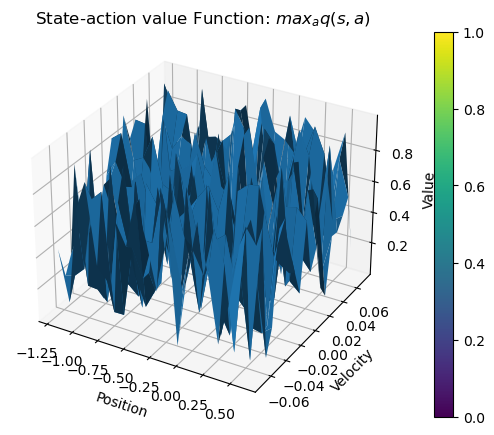

In [13]:
plot_cost_to_go_mountain_car(env, "q_value", agent.q)

## Linear approximation of state Value $V(s)$ 

We first are going to consider an parametrized estimation of the value function $$v_\pi(s) \sim \hat{v}(s,\bold{\theta})$$ with parameters $\bold{\theta}$. You can think of the process of generalization in two different ways :
- We simplify the problem by computing similarity elements between states  -> feature learning
- We extend the behavior of the policy to multiple states -> Optimization on a parametrized function class 

To do so, we introduce a mixture of gaussians that represent each state using `RBFSampler` from scikit-learn. 
Each state observation becomes an array of similarity between the current state point and a fix basis of point. The similarity is computed using a Gaussian kernel 


https://scikit-learn.org/stable/modules/kernel_approximation.html#rbf-kernel-approx

### Monte-Carlo State Value Approximation

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import Pipeline
import numpy as np
import torch

> Q.1 Complete and Analyze the behavior of the Linear Monte-Carlo State Value Approximation algorithm ( See Sutton Barto, 9.3 and 9.4) for multiple number of components.

In [19]:
n_actions = env.action_space.n

In [26]:
class MC_State_Value_Approximation:
    """MC State-value Learning with Function Approximation"""

    def __init__(self):
        """
        Init:
            gamma: discount factor
            preprocessing_states: preprocessing state features for better representation

            theta: linear weight (function approximation)
        """
        self.gamma = 0.9
        n_components = 3  # You can change
        self.preprocessing_states = Pipeline(
            [
                ("scaler", StandardScaler()),
                ("feature_generation", RBFSampler(n_components=n_components)),
            ]
        )
        self.preprocessing_states.fit(
            np.array(
                [
                    [np.random.uniform(-1.2, 0.6), np.random.uniform(-0.07, 0.07)]
                    for _ in range(10000)
                ]
            )
        )
        self.theta = np.zeros(n_components)  # Linear weights

    def preprocessing(self, state):
        """
        Return the featurized representation of a state.
        """
        return self.preprocessing_states.transform([state])[0]

    def act(self, state):
        """Output optimal action of a given state
        Returns: action in [0, 1, 2]
        """
        results = []
        for action in range(n_actions):
            observation, reward, terminated, truncated = (suggest_model(action, env))
            value = self.preprocessing(observation)
            results.append(value)

        idx_best = np.argsort(
            np.dot(np.array(results), self.theta)
        )[::-1]  # [::-1] to sort in descending order

        if np.random.uniform(0, 1) < 0.1:
            return np.random.choice(list(idx_best[1:]))
        else:
            return idx_best[0]

    def update(self, state, action, reward, new_state, terminal):

                
        
        self.theta = self.theta + 1e-3 * (target - self.v(state)) * self.preprocessing(
            state
        )
        pass

    def v(self, state):
        """Final V function.
        Return:
            Value (scalar): V(state)
        """
        return np.dot(self.preprocessing(state), self.theta)

> Q.2 Implement the Linear Semi-Gradient TD(0) : ( See Sutton Barto, 9.3 and 9.4). Analyze its behavior

> Q.3 Implement the n-step-TD State Value Approximation.  Analyze its behavior

# Deep-Q Learning with Experience Replay

>  ! experimental

> Fill the code bellow and analyse your training process, the behavior of the agent and conclude

We are going to train a Deep-Q network  https://arxiv.org/pdf/1312.5602.pdf on the break-out Atari game. Instead of a fixed basis to decompose the state, we will learn a representation of each state using a neural network.

![ChessUrl](https://gymnasium.farama.org/_images/breakout.gif "Frozen Lake")

In [ ]:
import gymnasium as gym
from gymnasium.utils.play import play


import random
import numpy as np

# import torch


# Play the game yourself
play(env=gym.make("BreakoutNoFrameskip-v4", render_mode="rgb_array"), zoom=4, fps=40)


## Processing game image

Raw Atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn from them.

We can thus save a lot of time by preprocessing game image, including

    Resizing to a smaller shape, 64x64
    Gray-scale the image
    Cropping irrelevant image parts (top, bottom and edges)


In [ ]:
from gymnasium.wrappers import GrayScaleObservation
from PIL import Image
import matplotlib.pyplot as plt

def observation(state):
    img = Image.fromarray(state)
    img = img.crop((8, 32, 152, 195))
    img = img.resize((64, 64))
    img = np.array(img, dtype=np.float32) / 255
    return img


env = gym.make("BreakoutNoFrameskip-v4", render_mode="rgb_array")
env = GrayScaleObservation(env)
state, _ = env.reset()
obs = observation(state)

%matplotlib inline
print("before cropping")
plt.imshow(state)
plt.show()
print("after cropping")
plt.imshow(obs,cmap="gist_gray")
plt.show()


## Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so it must be able to measure object's velocity. To do so, we introduce a buffer that stores 4 last images.

In [ ]:
from gymnasium.wrappers import FrameStack
from gymnasium.wrappers import ResizeObservation
from gymnasium.wrappers import TransformObservation

env = gym.make("BreakoutNoFrameskip-v4", render_mode="rgb_array")
env = GrayScaleObservation(env)
env = TransformObservation(env, lambda obs: observation(obs))
env = ResizeObservation(env, 64)
env = FrameStack(env, 4)
state, _ = env.reset()

plt.imshow(state[0], cmap="gist_gray")


## Building a network

We now need to build a neural network that can map images to state q-values. This network will be called on every agent's step so it better not be resnet-152 unless you have an array of GPUs. Instead, you can use strided convolutions with a small number of features to save time and memory.

You can build any architecture you want, but for reference, here's something that will more or less work:


![Alt text](dqn.png)

We are using pytorch https://pytorch.org/docs/stable/index.html 

In [ ]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def conv2d_size_out(size, kernel_size, stride):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride + 1

class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        # Define your network body here. Please make sure agent is fully contained here
        # nn.Flatten() can be useful
        
        

    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        # Use your network to compute qvalues for given state
        qvalues = 

        assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"
        assert (
            len(qvalues.shape) == 2 and 
            qvalues.shape[0] == state_t.shape[0] and 
            qvalues.shape[1] == n_actions
        )

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)
     

> Evaluate your agent on this function

In [ ]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000, seed=None):
    """Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward."""
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset(seed=seed)
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = (
                qvalues.argmax(axis=-1)[0]
                if greedy
                else agent.sample_actions(qvalues)[0]
            )
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [ ]:
state_shape = (4, 64, 64)
n_actions = env.action_space.n
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

## Experience Replay

For this assignment, we provide you with experience replay buffer. This constitute your "training set"

![Alt text](exp_replay.png)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [ ]:
from utils import ReplayBuffer

exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(), 1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(5)

assert (
    len(exp_replay) == 10
), "experience replay size should be 10 because that's what maximum capacity is"

In [ ]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n_steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    <YOUR CODE>

    return sum_rewards, s

In [ ]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state,_ = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, (
    "play_and_record should have added exactly 1000 steps, "
    "but instead added %i" % len(exp_replay)
)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, (
    "Please make sure you restart the game whenever it is 'done' and "
    "record the is_done correctly into the buffer. Got %f is_done rate over "
    "%i steps. [If you think it's your tough luck, just re-run the test]"
    % (np.mean(is_dones), len(exp_replay))
)

for _ in range(100):
    (
        obs_batch,
        act_batch,
        reward_batch,
        next_obs_batch,
        is_done_batch,
    ) = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (
        10,
    ), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (
        10,
    ), "rewards batch should have shape (10,) but is instead %s" % str(
        reward_batch.shape
    )
    assert is_done_batch.shape == (
        10,
    ), "is_done batch should have shape (10,) but is instead %s" % str(
        is_done_batch.shape
    )
    assert [
        int(i) in (0, 1) for i in is_dones
    ], "is_done should be strictly True or False"
    assert [
        0 <= a < n_actions for a in act_batch
    ], "actions should be within [0, n_actions)"

print("Well done!")

### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png)

In [ ]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes Q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

In [ ]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float32)    # shape: [batch_size, *state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float32,
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)  # shape: [batch_size, n_actions]

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)  # shape: [batch_size, n_actions]
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]  # shape: [batch_size]

    # compute V*(next_states) using predicted next q-values
    next_state_values = <YOUR CODE>

    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], \
        "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = <YOUR CODE>

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, \
            "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, \
            "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, \
            "there's something wrong with target q-values, they must be a vector"

    return loss

In [ ]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10
)

loss = compute_td_loss(
    obs_batch,
    act_batch,
    reward_batch,
    next_obs_batch,
    is_done_batch,
    agent,
    target_network,
    gamma=0.99,
    check_shapes=True,
)
loss.backward()

assert (
    loss.requires_grad and tuple(loss.data.size()) == ()
), "you must return scalar loss - mean over batch"
assert np.any(
    next(agent.parameters()).grad.data.cpu().numpy() != 0
), "loss must be differentiable w.r.t. network weights"
assert np.all(
    next(target_network.parameters()).grad is None
), "target network should not have grads"

## Main loop

**If deadline is tonight and it has not converged:** It is ok. Send the notebook today and when it converges send it again.
If the code is exactly the same points will not be discounted.

It's time to put everything together and see if it learns anything.

In [ ]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
env = gym.make("BreakoutNoFrameskip-v4", render_mode="rgb_array")
env = GrayScaleObservation(env)
env = TransformObservation(env, lambda obs: observation(obs))
env = ResizeObservation(env, 64)
env = FrameStack(env, 4)


state_shape = env.observation_space.shape
n_actions = env.action_space.n
state,_ = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

Buffer of size $10^4$ fits into 5 Gb RAM.

Larger sizes ($10^5$ and $10^6$ are common) can be used. It can improve the learning, but $10^4$ is quite enough. $10^2$ will probably fail learning.

In [ ]:
REPLAY_BUFFER_SIZE = 10**4
N_STEPS = 100

exp_replay = ReplayBuffer(REPLAY_BUFFER_SIZE)
for i in trange(REPLAY_BUFFER_SIZE // N_STEPS):
    play_and_record(state, agent, env, exp_replay, n_steps=N_STEPS)
    if len(exp_replay) == REPLAY_BUFFER_SIZE:
        break
print(len(exp_replay))


In [ ]:
timesteps_per_epoch = 1
batch_size = 16
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [ ]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []
step = 0

In [ ]:
import time


def wait_for_keyboard_interrupt():
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        pass

In [ ]:
state,_ = env.reset()
with trange(step, total_steps + 1) as progress_bar:
    for step in progress_bar:
        if not utils.is_enough_ram():
            print('less that 100 Mb RAM available, freezing')
            print('make sure everything is ok and use KeyboardInterrupt to continue')
            wait_for_keyboard_interrupt()

        agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

        # play
        _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

        # train
        <YOUR CODE: sample batch_size of data from experience replay>

        loss = <YOUR CODE: compute TD loss>

        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
        opt.step()
        opt.zero_grad()

        if step % loss_freq == 0:
            td_loss_history.append(loss.data.cpu().item())
            grad_norm_history.append(grad_norm.cpu())

        if step % refresh_target_network_freq == 0:
            # Load agent weights into target_network
            <YOUR CODE>

        if step % eval_freq == 0:
            mean_rw_history.append(evaluate(
                make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
            )
            initial_state_q_values = agent.get_qvalues(
                [make_env(seed=step).reset()]
            )
            initial_state_v_history.append(np.max(initial_state_q_values))

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" %
                (len(exp_replay), agent.epsilon))

            plt.figure(figsize=[16, 9])

            plt.subplot(2, 2, 1)
            plt.title("Mean reward per life")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(td_loss_history[-1])
            plt.subplot(2, 2, 2)
            plt.title("TD loss history (smoothened)")
            plt.plot(utils.smoothen(td_loss_history))
            plt.grid()

            plt.subplot(2, 2, 3)
            plt.title("Initial state V")
            plt.plot(initial_state_v_history)
            plt.grid()

            plt.subplot(2, 2, 4)
            plt.title("Grad norm history (smoothened)")
            plt.plot(utils.smoothen(grad_norm_history))
            plt.grid()

            plt.show()

Agent is evaluated for 1 life, not for a whole episode of 5 lives. Rewards in evaluation are also truncated. Cuz this is what environment the agent is learning in and in this way mean rewards per life can be compared with initial state value

**The goal is to get 15 points in the real env**. So 3 or better 4 points in the preprocessed one will probably be enough. You can interrupt learning then.

Final scoring is done on a whole episode with all 5 lives.

In [ ]:
final_score = evaluate(
    env,
    agent,
    n_games=30,
    greedy=True,
    t_max=10 * 1000,
)
print("final score:", final_score)
assert final_score >= 3, "not as cool as DQN can"
print("Cool!")

## How to interpret plots:

This aint no supervised learning so don't expect anything to improve monotonously. 
* **TD loss** is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* **grad norm** just shows the intensivity of training. Not ok is growing to values of about 100 (or maybe even 50) though it depends on network architecture.
* **mean reward** is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...). 
 * In basic q-learning implementation it takes about 40k steps to "warm up" agent before it starts to get better.
* **Initial state V** is the expected discounted reward for episode in the oppinion of the agent. It should behave more smoothly than **mean reward**. It should get higher over time but sometimes can experience drawdowns because of the agaent's overestimates.
* **buffer size** - this one is simple. It should go up and cap at max size.
* **epsilon** - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - it means you need to increase epsilon. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Smoothing of plots is done with a gaussian kernel

At first your agent will lose quickly. Then it will learn to suck less and at least hit the ball a few times before it loses. Finally it will learn to actually score points.

**Training will take time.** A lot of it actually. Probably you will not see any improvment during first **150k** time steps (note that by default in this notebook agent is evaluated every 5000 time steps).


## About hyperparameters:

The task has something in common with supervised learning: loss is optimized through the buffer (instead of Train dataset). But the distribution of states and actions in the buffer **is not stationary** and depends on the policy that generated it. It can even happen that the mean TD error across the buffer is very low but the performance is extremely poor (imagine the agent collecting data to the buffer always manages to avoid the ball).

* Total timesteps and training time: It seems to be so huge, but actually it is normal for RL.

* $\epsilon$ decay shedule was taken from the original paper and is like traditional for epsilon-greedy policies. At the beginning of the training the agent's greedy policy is poor so many random actions should be taken.

* Optimizer: In the original paper RMSProp was used (they did not have Adam in 2013) and it can work not worse than Adam. For us Adam was default and it worked.

* lr: $10^{-3}$ would probably be too huge

* batch size: This one can be very important: if it is too small the agent can fail to learn. Huge batch takes more time to process. If batch of size 8 can not be processed on the hardware you use take 2 (or even 4) batches of size 4, divide the loss on them by 2 (or 4) and make optimization step after both backward() calls in torch.

* target network update frequency: has something in common with learning rate. Too frequent updates can lead to divergence. Too rare can lead to slow leraning. For millions of total timesteps thousands of inner steps seem ok. One iteration of target network updating is an iteration of the (this time approximate) $\gamma$-compression that stands behind Q-learning. The more inner steps it makes the more accurate is the compression.
* max_grad_norm - just huge enough. In torch clip_grad_norm also evaluates the norm before clipping and it can be convenient for logging.

_Parts of this practical have been taken or adapted from https://github.com/yandexdataschool/Practical_RL/_